In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sipm.util.functions as func
import pandas as pd
import glob
import scipy
from scipy.interpolate import interp1d
import csv
import os
from sipm.analysis.SipmCalibration import SipmCalibration
import yaml

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
!pwd


/home/as111/sipm-analysis


## Example waveforms

/scratch/gpfs/GALBIATI/data/sipm//hamamatsu_test/2023-06-07/2023-06-07_volt_90_light_laser_config_1_cond_ln_intensity_1020/wave0.dat
50799 events


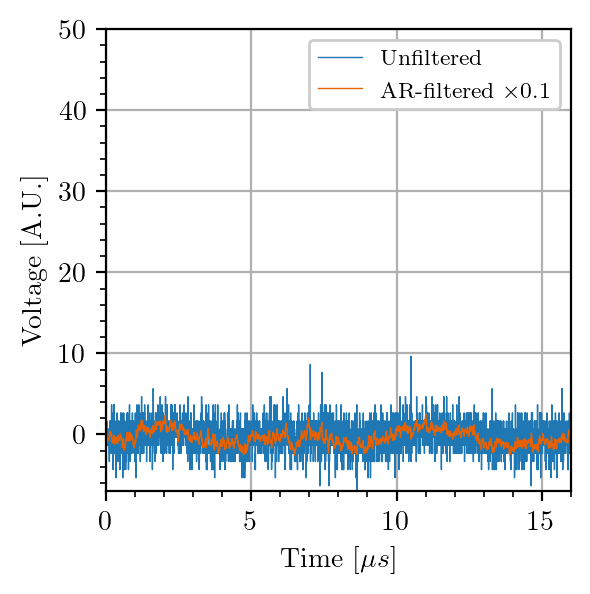

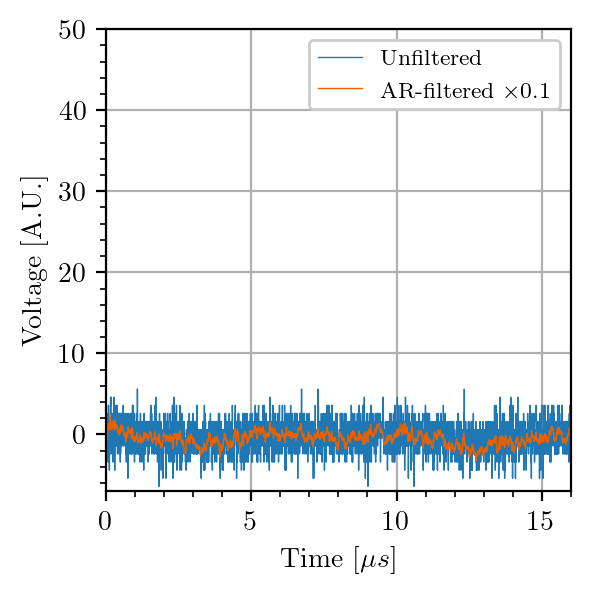

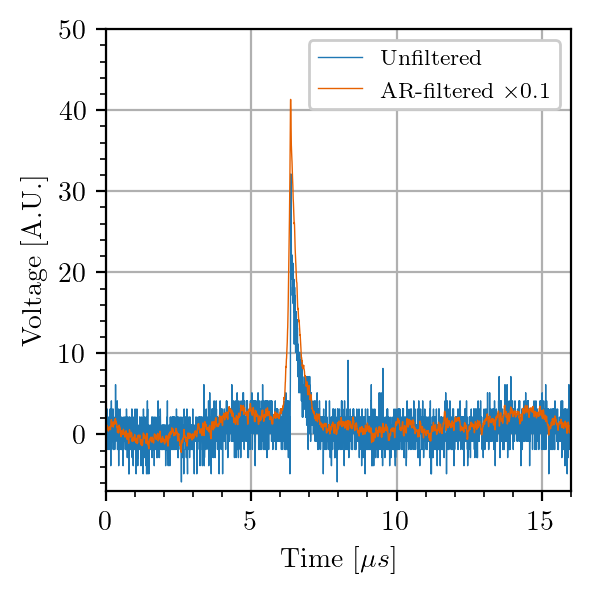

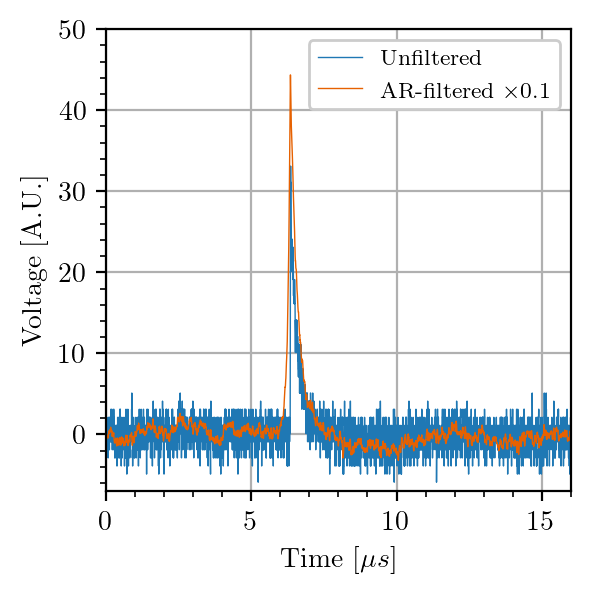

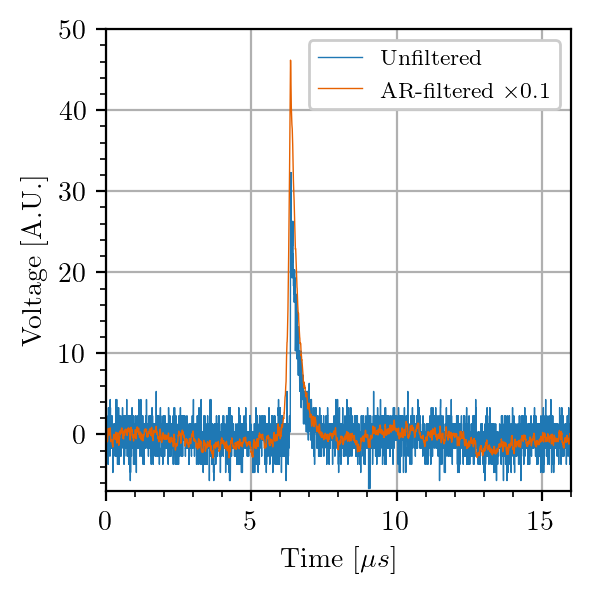

In [6]:
import sipm.recon.WaveformDataset as wfd
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/hamamatsu_test/'
direc = '2023-06-07/2023-06-07_volt_90_light_laser_config_1_cond_ln_intensity_1020/'
ch = 0
evid = np.arange(5, 10)
dset = wfd.WaveformDataset(path='{}{}'.format(
    data_dir, direc), pol=-1, channels=range(4))
wfs, arwfs = dset.ch[ch].get_waveforms(ev=evid, ar_filter=True)

for i, wf in enumerate(wfs):
    plt.figure(i, figsize=(3, 3))
    plt.plot(dset.ch[ch].time, wf, label='Unfiltered', linewidth=0.5)
    plt.plot(dset.ch[ch].time, arwfs[i]*0.1,
             label=r'AR-filtered $\times0.1$', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.xlabel(r'Time [$\mu s$]')
    plt.ylabel(r'Voltage [A.U.]')
    plt.minorticks_on()
    plt.grid()
    plt.xlim(0, 16)
    plt.ylim(-7, 50)

# Load pre-processed h5 files
These files should be processed by `exe/laser_pulse.py` script.

In [25]:
intensities = [1020,1120]
voltages = [90,92]
channels = [0,1,2,3]
directory = '/scratch/gpfs/as111/results/'
date = '2023-06-07'
verbose = True

metadata_dict = {}
for intn in intensities:
    metadata_dict[intn] = {}
    for ch in channels:
        metadata_dict[intn][ch] = {}
        for volt in voltages:
            metadata_dict[intn][ch][volt] = {'metadata':{
                'date':'2023-06-07',
                'volt': volt,
                'light': 'laser',
                'cond': f'ln_intensity_{intn}',
                'config': 1,
                'intensity': intn,
                'run': '*',
                'ch': ch
            }}
            files = glob.glob(f"{directory}{date}/{date}_volt_{volt}_light_laser_cond_ln_intensity_{intn}_config_1_intensity_{intn}_run0_laser_pulse.h5")
            data = []
            for f in files:
                ind = f.find('run')+3
                run_number = int(f[ind:f.find('_',ind)])
                df = pd.read_hdf(f, key=f'{volt}/{ch}')
                df['event'] = df.index
                df['run'] = np.array([run_number]*df.shape[0])
                data.append(df)
            if len(files)>0:
                data = pd.concat(data, ignore_index=True).sort_values(by=['run','event']).reset_index(drop=True)
            metadata_dict[intn][ch][volt]['data'] = data
            if verbose:
                if len(files)==0:
                    events = 0
                else:
                    keys = data.keys()
                    events = len(data[keys[0]])
                print(f'{date} {volt}V intensity={intn} ch{ch} - {len(files)} files {events} events')

2023-06-07 90V intensity=1020 ch0 - 1 files 50799 events
2023-06-07 92V intensity=1020 ch0 - 1 files 50687 events
2023-06-07 90V intensity=1020 ch1 - 1 files 50799 events
2023-06-07 92V intensity=1020 ch1 - 1 files 50687 events
2023-06-07 90V intensity=1020 ch2 - 1 files 50799 events
2023-06-07 92V intensity=1020 ch2 - 1 files 50687 events
2023-06-07 90V intensity=1020 ch3 - 1 files 50799 events
2023-06-07 92V intensity=1020 ch3 - 1 files 50687 events
2023-06-07 90V intensity=1120 ch0 - 1 files 51129 events
2023-06-07 92V intensity=1120 ch0 - 1 files 50649 events
2023-06-07 90V intensity=1120 ch1 - 1 files 51129 events
2023-06-07 92V intensity=1120 ch1 - 1 files 50649 events
2023-06-07 90V intensity=1120 ch2 - 1 files 51129 events
2023-06-07 92V intensity=1120 ch2 - 1 files 50649 events
2023-06-07 90V intensity=1120 ch3 - 1 files 51129 events
2023-06-07 92V intensity=1120 ch3 - 1 files 50649 events


## Baseline quality cut
To avoid pre-trigger pulses or abnormal fluctuations, we require that the RMS variation in the baseline region ($t<t_{\rm trigger}-0.5~\rm\mu s$) be less than $2.5$ ADC units.
This baseline cut normalizes the baseline mean distribution.
Cut fraction is around $0.1\%$ ($2\%$) for the top (bottom) tile.

In [28]:
verbose = True
thre_ch = [2.,6.,1.5,1.5]
mybsl = {}
for intn in intensities:
    mybsl[intn] = {}
    for ch in channels:
        mybsl[intn][ch] = {}
        for volt in voltages:
            mybsl[intn][ch][volt] = {'rms_threshold': thre_ch[ch]}
            data = metadata_dict[intn][ch][volt]['data']
            data['bsl_cut'] = data['baseline_rms']<mybsl[intn][ch][volt]['rms_threshold']
            rms_hist, rms_bins = np.histogram(data['baseline_rms'], bins=500, range=(0, 8))
            mean_hist, mean_bins = np.histogram(data['baseline_mean'], bins=1500, range=(3760, 3860))
            mean_hist_cut, mean_bins_cut = np.histogram(data['baseline_mean'].loc[data['bsl_cut']], bins=1500, range=(3760, 3860))
            cut_fraction = 1-np.sum(data['bsl_cut'])/data.shape[0]
            mybsl[intn][ch][volt].update({
                'rms_hist':rms_hist, 'rms_bins':rms_bins,
                'mean_hist':mean_hist, 'mean_bins':mean_bins,
                'mean_hist_cut':mean_hist_cut, 'mean_bins_cut':mean_bins_cut,
                'cut_fraction':cut_fraction
            })
            if verbose:
                print(f'{volt}V ch{ch} intensity={intn} cut fraction = {cut_fraction*100:.5f}%')
            

90V ch0 intensity=1020 cut fraction = 1.11223%
92V ch0 intensity=1020 cut fraction = 0.73392%
90V ch1 intensity=1020 cut fraction = 0.56891%
92V ch1 intensity=1020 cut fraction = 0.80889%
90V ch2 intensity=1020 cut fraction = 1.69492%
92V ch2 intensity=1020 cut fraction = 1.68090%
90V ch3 intensity=1020 cut fraction = 0.07087%
92V ch3 intensity=1020 cut fraction = 0.09667%
90V ch0 intensity=1120 cut fraction = 3.28581%
92V ch0 intensity=1120 cut fraction = 3.75526%
90V ch1 intensity=1120 cut fraction = 1.85805%
92V ch1 intensity=1120 cut fraction = 3.96651%
90V ch2 intensity=1120 cut fraction = 3.23300%
92V ch2 intensity=1120 cut fraction = 3.97836%
90V ch3 intensity=1120 cut fraction = 0.07237%
92V ch3 intensity=1120 cut fraction = 0.06515%


Text(0.07, 0.5, 'Count')

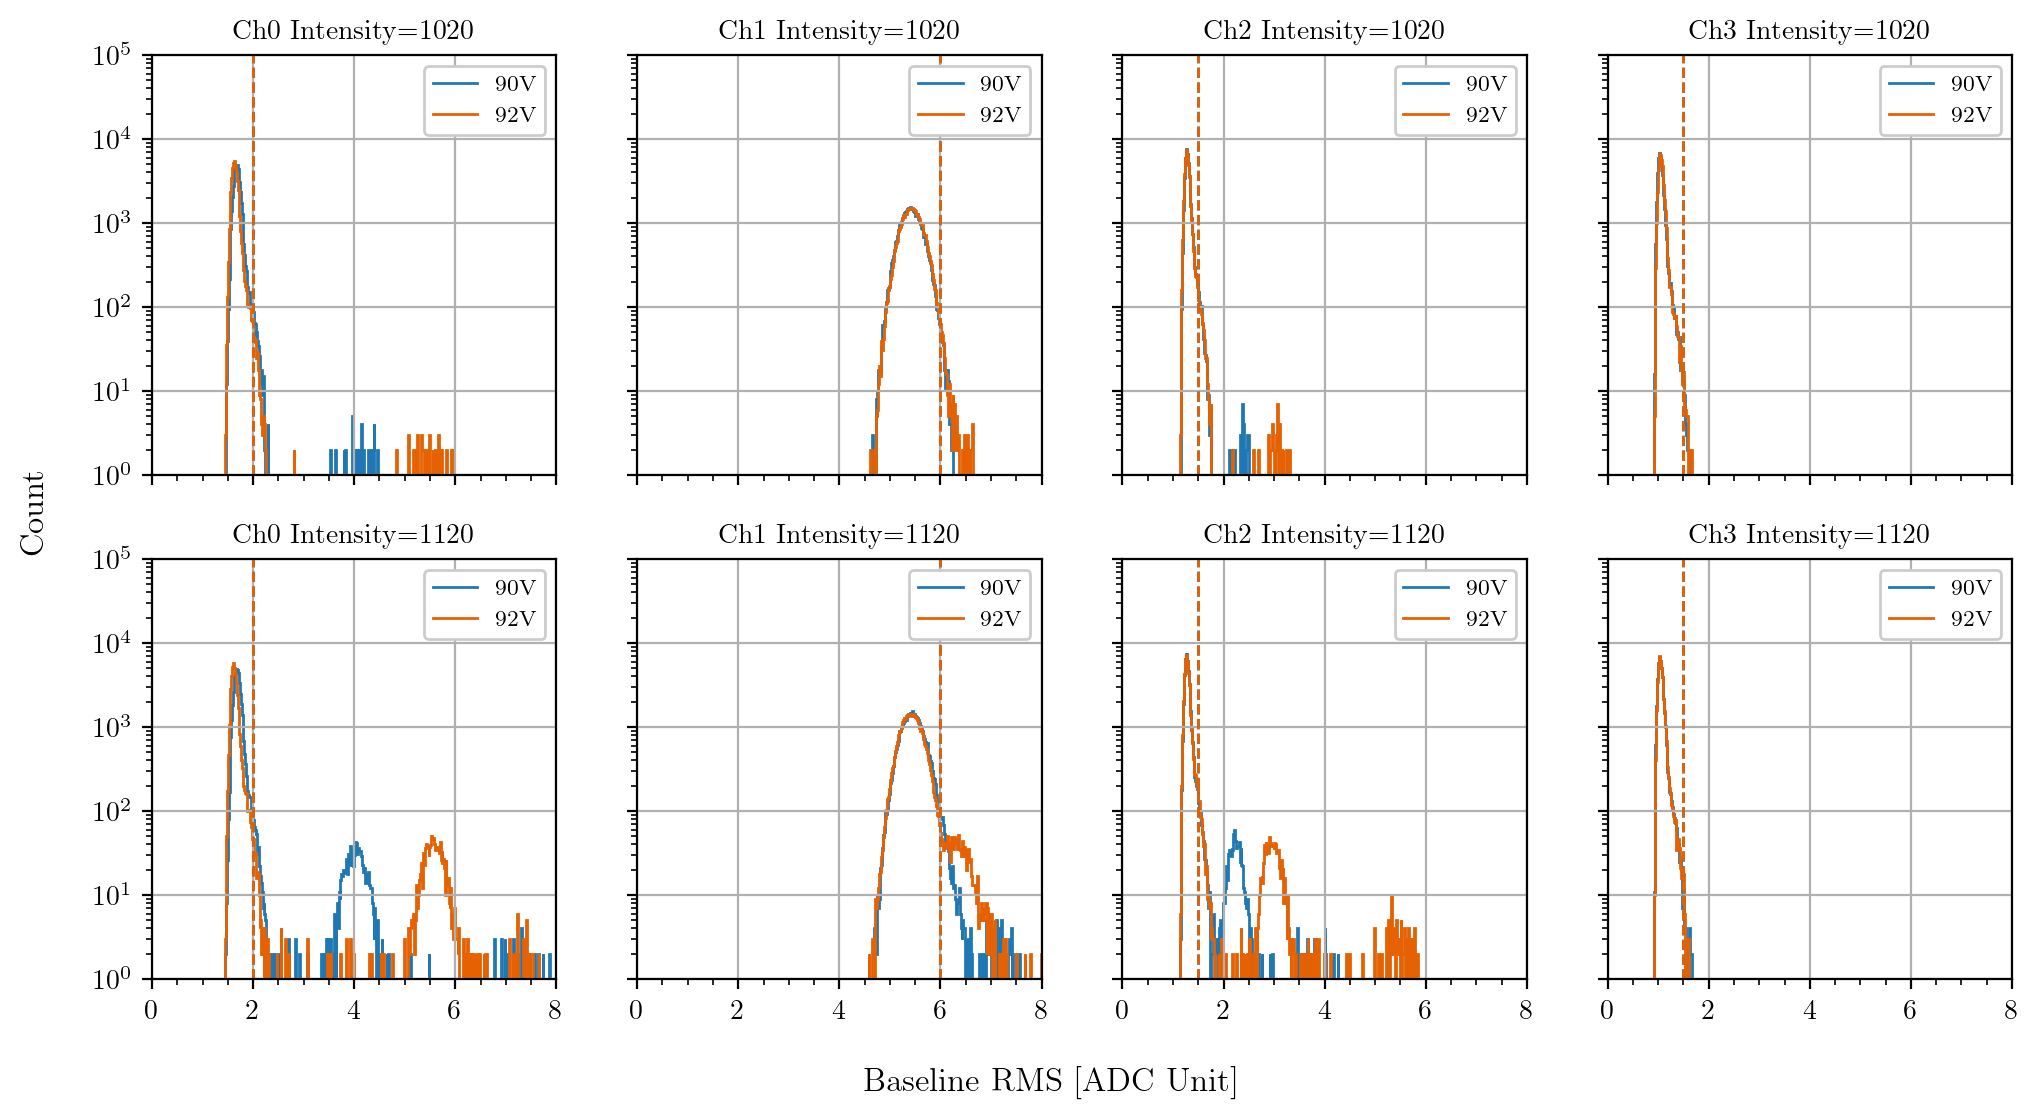

In [29]:
# Make plots for all datasets
# Baseline RMS
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, intn in enumerate(intensities):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            axs[i, j].stairs(mybsl[intn][ch][volt]['rms_hist'],
                             mybsl[intn][ch][volt]['rms_bins'],
                             label=f'{volt}V', color=f'C{k}')
            th = mybsl[intn][ch][volt]['rms_threshold']
            axs[i, j].plot([th, th], [1, 1e5], f'C{k}--', linewidth=1)
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_ylim(1, 1e5)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'Ch{ch} Intensity={intn}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0.01)
fig.supylabel('Count', x=0.07)

Text(0.07, 0.5, 'Count')

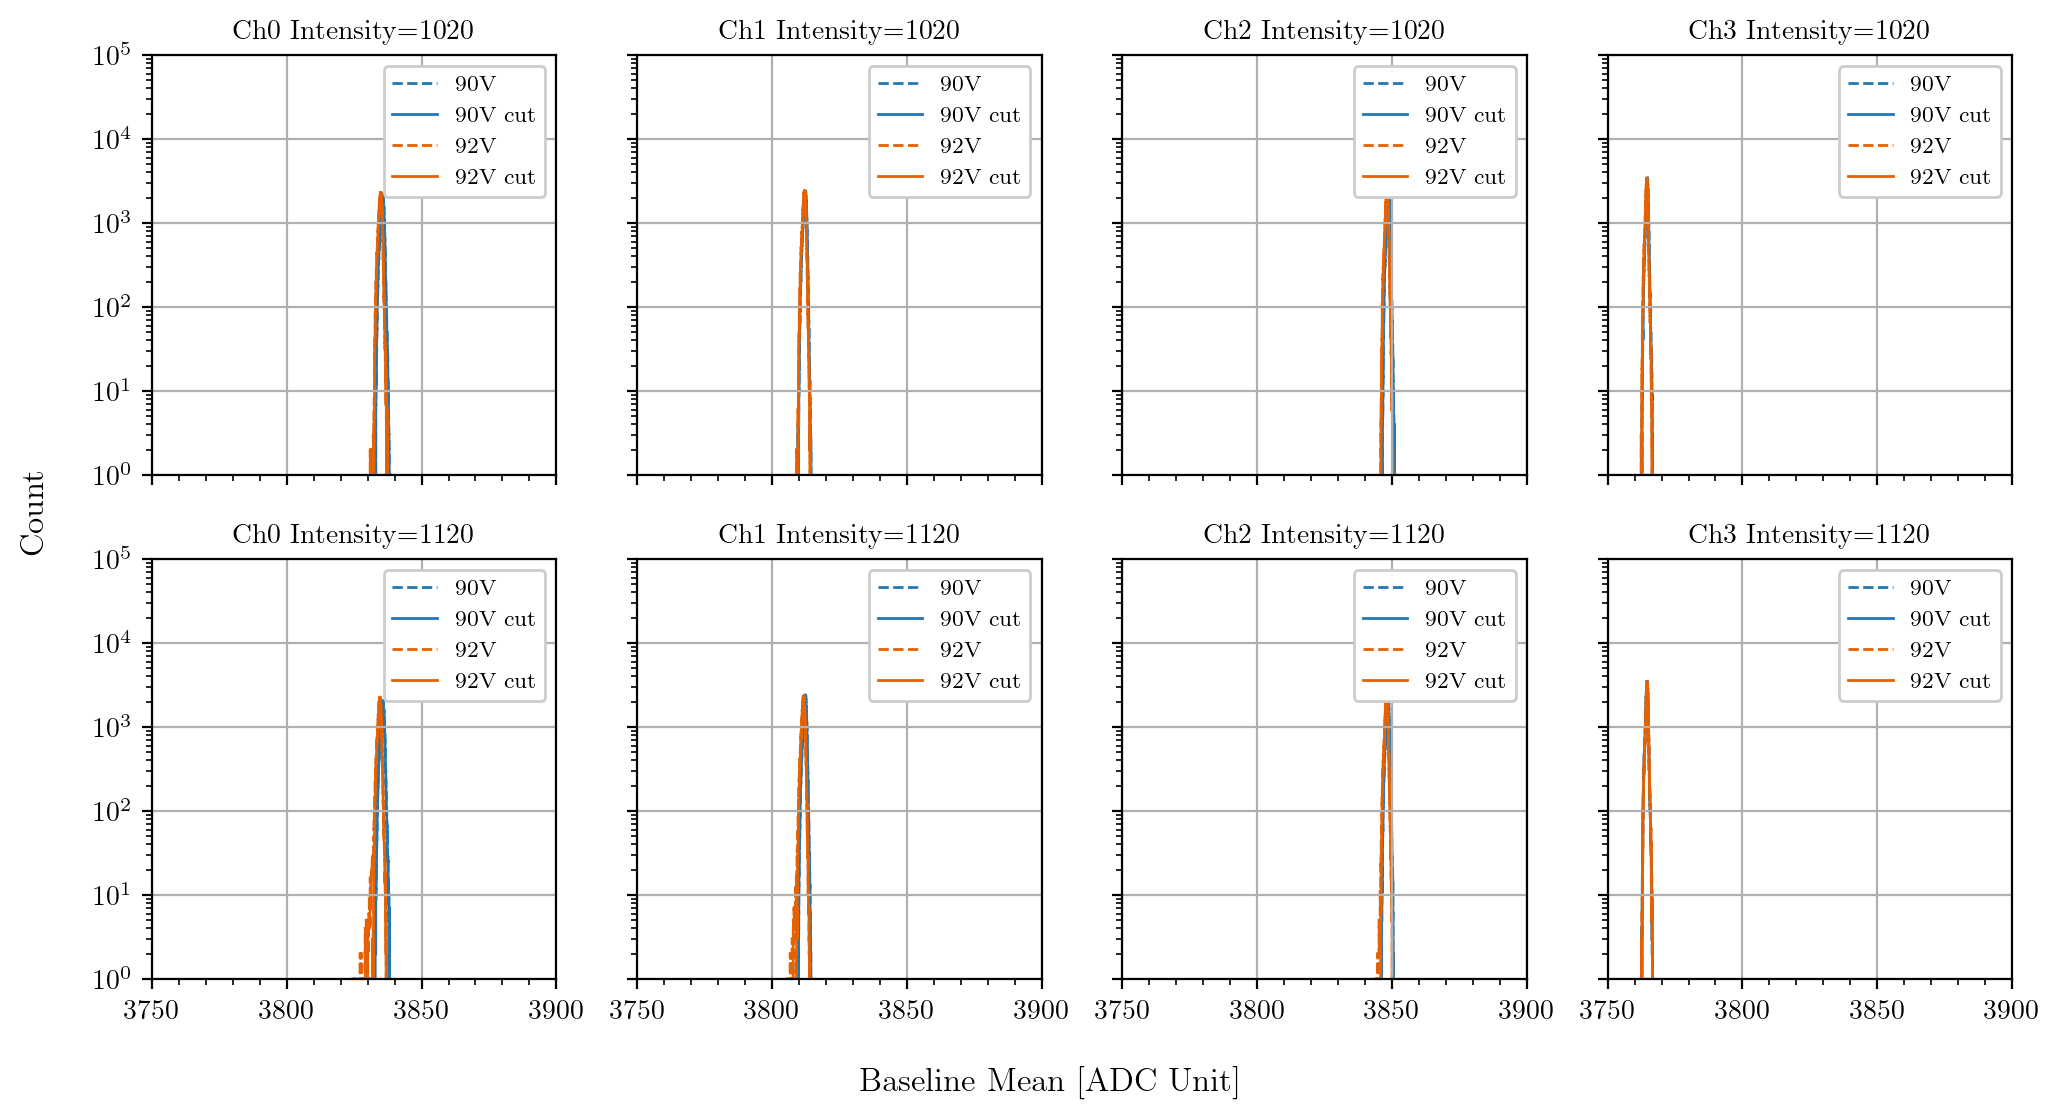

In [30]:
# Make plots for all datasets
# Baseline mean
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, intn in enumerate(intensities):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            axs[i, j].stairs(mybsl[intn][ch][volt]['mean_hist'],
                             mybsl[intn][ch][volt]['mean_bins'],
                             label=f'{volt}V', color=f'C{k}', linestyle='--')
            axs[i, j].stairs(mybsl[intn][ch][volt]['mean_hist_cut'],
                             mybsl[intn][ch][volt]['mean_bins_cut'],
                             label=f'{volt}V cut', color=f'C{k}')
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_ylim(1, 1e5)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'Ch{ch} Intensity={intn}')
fig.supxlabel('Baseline Mean [ADC Unit]', y=0.01)
fig.supylabel('Count', x=0.07)

Plots for intensity=1020 ch3 90V


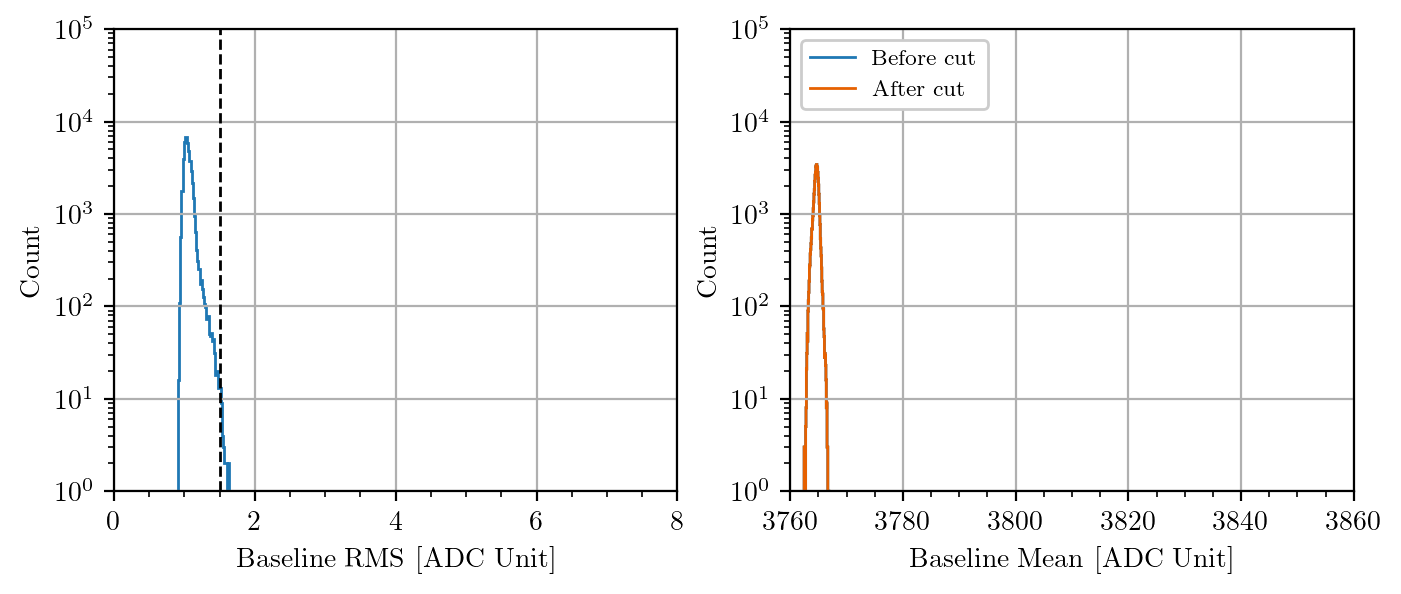

In [35]:
# Make plots for selected dataset
intn = 1020
ch = 3
volt = 90
print(f'Plots for intensity={intn} ch{ch} {volt}V')
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)

# rms
axs[0].stairs(mybsl[intn][ch][volt]['rms_hist'],
              mybsl[intn][ch][volt]['rms_bins'])
th = mybsl[intn][ch][volt]['rms_threshold']
axs[0].plot([th, th], [1, 1e5], 'k--', linewidth=1)
axs[0].set_ylim(1, 1e5)
axs[0].set_yscale('log')
axs[0].set_xlabel('Baseline RMS [ADC Unit]')
axs[0].set_ylabel('Count')
axs[0].minorticks_on()
axs[0].grid()

# mean
axs[1].stairs(mybsl[intn][ch][volt]['mean_hist'],
              mybsl[intn][ch][volt]['mean_bins'],
              label='Before cut')
axs[1].stairs(mybsl[intn][ch][volt]['mean_hist_cut'],
              mybsl[intn][ch][volt]['mean_bins_cut'],
              label='After cut')
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_ylim(1, 1e5)
axs[1].set_xlim(3760, 3860)
axs[1].set_xlabel('Baseline Mean [ADC Unit]')
axs[1].set_ylabel('Count')
axs[1].minorticks_on()
axs[1].grid()

## Filtered amplitude & DiCT analysis
The PE peak positions are identified with ``scipy.signal.find_peaks``.
Let $A_k$ be the peak position of the $k$-PE peak (including $k=0$). 
The boundary between $k-1$ PEs and $k$ PEs is defined as $(A_{k-1}+A_{k})/2$.
The lower boundary of the 0th PE is $A_0-0.5(A_1-A_0)$ and similarly for the upper boundary of the highest identifiable PE.
One exception is bottom ch3 which has asymmetric peaks. See code for the modified boundary criterion.
The vertical dashed lines in the finger plots represent the boundaries.

Let $P_k$ be the fraction of events within the $k$-PE boundaries. 
It can be fitted by the [compound Poisson distribution](https://ieeexplore.ieee.org/document/5402300) describing a binomial chain process, with parameter $p$ being the DiCT probability and $\mu$ being the Poisson mean of primary PEs.

In [83]:
boundary_par_dict = {}
amp_hist = {}
crosstalk = {}
nbins=1500
hist_range=(-5e2, 5e3)
bin_width = (hist_range[1]-hist_range[0])/nbins
prom,wid,dist=30,5,50
for intn in intensities:
    boundary_par_dict[intn] = {}
    amp_hist[intn] = {}
    crosstalk[intn] = {}
    for ch in channels:
        boundary_par_dict[intn][ch] = {}
        amp_hist[intn][ch] = {}
        crosstalk[intn][ch] = {}
        for volt in voltages:
            amp_hist[intn][ch][volt] = {}
            crosstalk[intn][ch][volt] = {}
            boundary_par_dict[intn][ch][volt] = 0.5
            nevents = np.sum(metadata_dict[intn][ch][volt]['data']['bsl_cut'])
            amp_hist[intn][ch][volt]['hist'], amp_hist[intn][ch][volt]['bins'] = np.histogram(
                metadata_dict[intn][ch][volt]['data']['amplitude_trig'].loc[metadata_dict[intn][ch][volt]['data']['bsl_cut']], 
                bins=nbins, range=hist_range
            )
            # find PE peaks in histogram
            p, pdict = scipy.signal.find_peaks(
                amp_hist[intn][ch][volt]['hist'], prominence=prom, width=wid, distance=dist)
            print(f'intensity={intn} {volt}V ch{ch}', p, pdict)
            # discriminate different PE counts and calculate probability distribution P_k
            metadata_dict[intn][ch][volt]['data']['pe'] = np.zeros(metadata_dict[intn][ch][volt]['data'].shape[0]).astype(int)
            P_k = []
            npe = len(p)
            pe_cuts_in_bins = []
            bound_par = boundary_par_dict[intn][ch][volt]
            if npe>1:
                for ipe in range(npe):
                    if ipe == 0:
                        pe_cuts_in_bins.append(int(1.5*p[0]-0.5*p[1]))
                    else:
                        pe_cuts_in_bins.append(int(bound_par*p[ipe]+(1-bound_par)*p[ipe-1]))
                        metadata_dict[intn][ch][volt]['data']['pe'] += (metadata_dict[intn][ch][volt]['data']['amplitude_trig']>pe_cuts_in_bins[-1]*bin_width+hist_range[0]).astype(int)
                        P_k.append([np.sum(amp_hist[intn][ch][volt]['hist'][pe_cuts_in_bins[ipe-1]:pe_cuts_in_bins[ipe]])/nevents,
                                np.sqrt(np.sum(amp_hist[intn][ch][volt]['hist'][pe_cuts_in_bins[ipe-1]:pe_cuts_in_bins[ipe]]))/nevents])
            amp_hist[intn][ch][volt]['boundaries'] = list(
                np.array(pe_cuts_in_bins)*bin_width+hist_range[0])
            # Save P_k for Vinogradov fit
            if npe>1:
                crosstalk[intn][ch][volt]['y'] = np.array(P_k)[:, 0]
                crosstalk[intn][ch][volt]['yerr'] = np.array(P_k)[:, 1]
                crosstalk[intn][ch][volt]['x'] = np.arange(len(P_k))

intensity=1020 90V ch0 [136 232 353 470 581] {'prominences': array([1184.,  439.,  325.,  143.,   60.]), 'left_bases': array([118, 213, 301, 408, 523]), 'right_bases': array([153, 281, 854, 854, 854]), 'widths': array([ 7.7911802 , 35.76792498, 33.89772727, 45.32467532, 40.87878788]), 'width_heights': array([592. , 219.5, 162.5,  73.5,  36. ]), 'left_ips': array([132.17989418, 227.54938272, 339.47727273, 445.31818182,
       563.66666667]), 'right_ips': array([139.97107438, 263.31730769, 373.375     , 490.64285714,
       604.54545455])}
intensity=1020 92V ch0 [135 283 457 627 775] {'prominences': array([1129.,  408.,  290.,  132.,   60.]), 'left_bases': array([119, 264, 394, 511, 695]), 'right_bases': array([ 152,  333,  511, 1137, 1137]), 'widths': array([ 8.20899538, 36.43855562, 34.72670807, 51.7       , 10.76923077]), 'width_heights': array([564.5, 204. , 145. ,  66. ,  34. ]), 'left_ips': array([131.18717949, 276.29411765, 438.13043478, 590.13333333,
       769.        ]), 'right

Text(0.07, 0.5, 'Count')

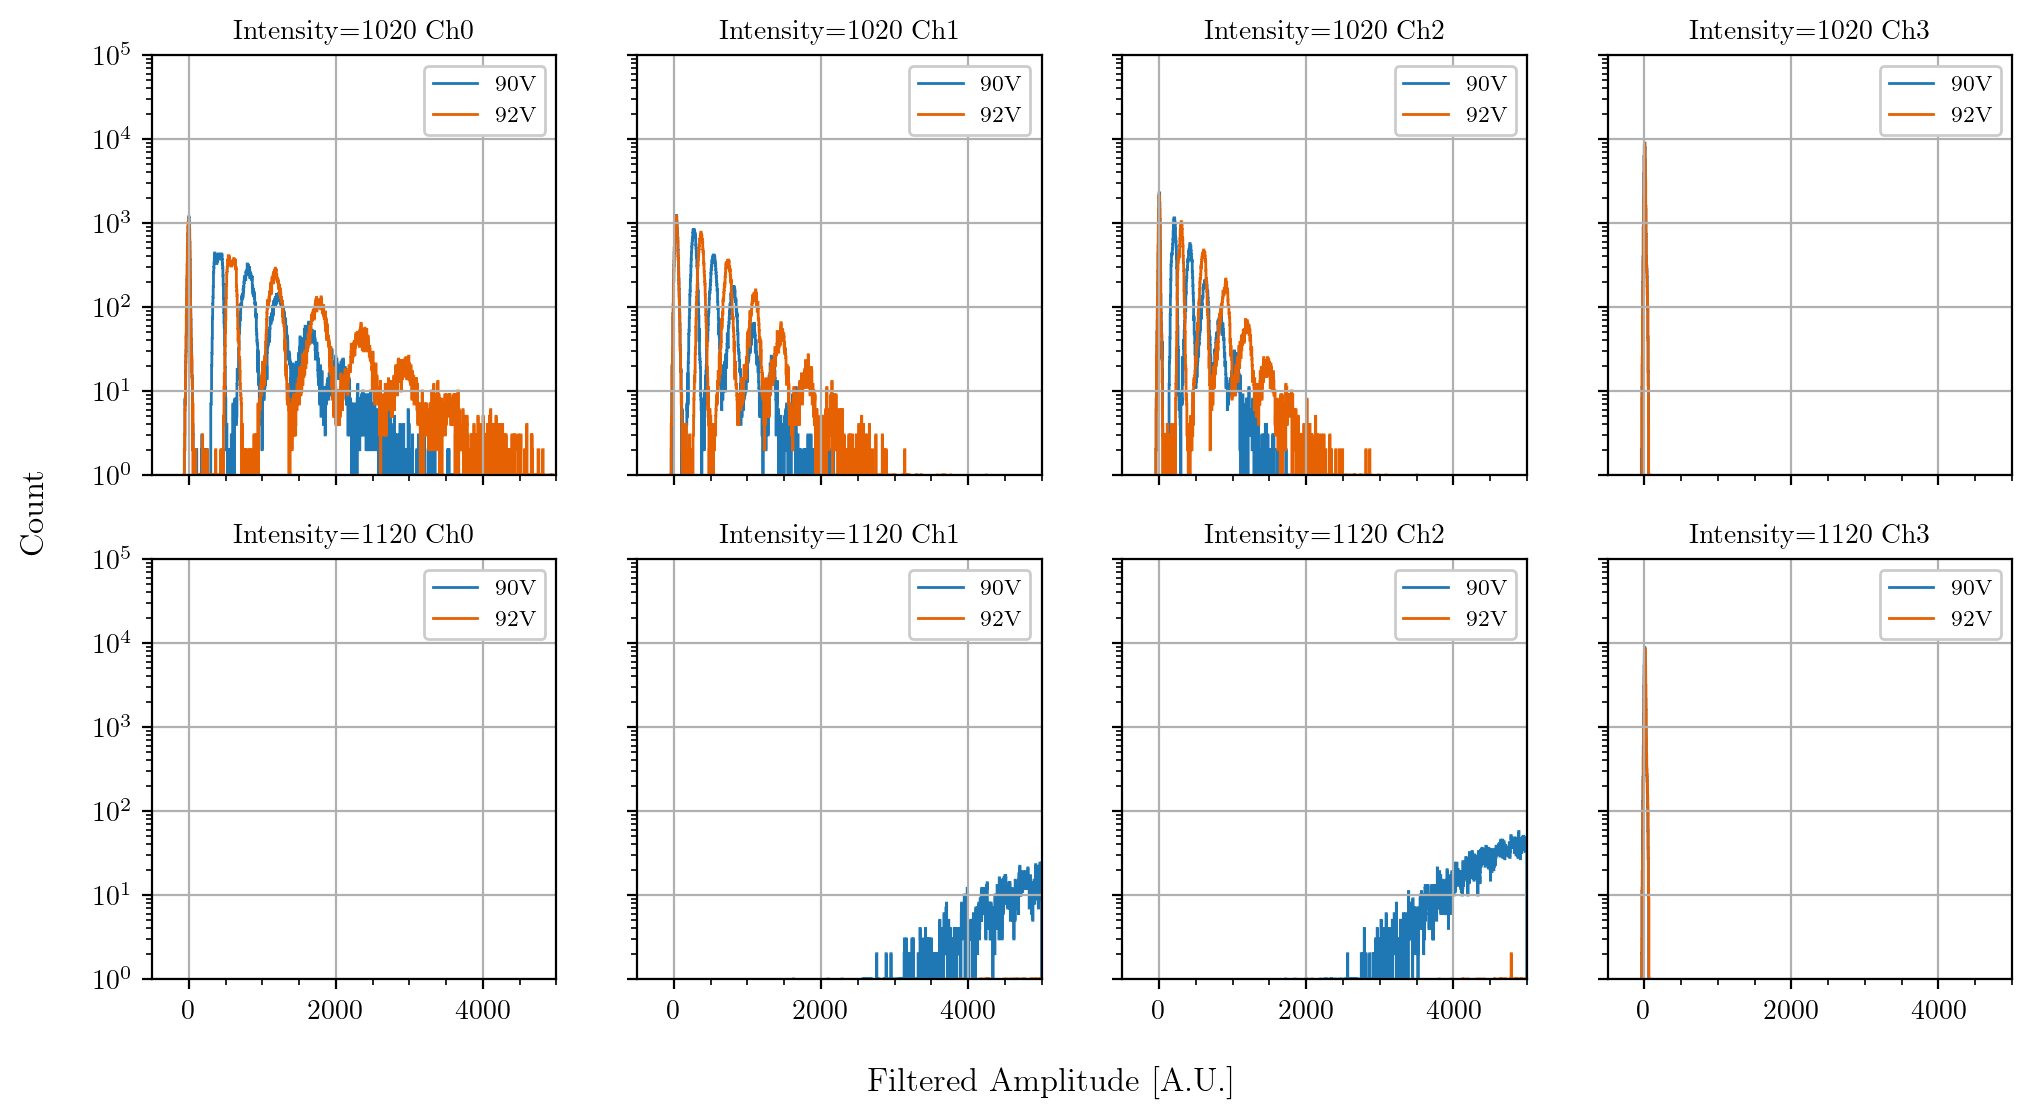

In [84]:
# Make plots for all datasets
# Finger plots
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, intn in enumerate(intensities):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            axs[i, j].stairs(amp_hist[intn][ch][volt]['hist'],
                             amp_hist[intn][ch][volt]['bins'],
                             label=f'{volt}V', color=f'C{k}')
        axs[i, j].legend(loc='upper right')
        axs[i, j].set_ylim(1, 1e5)
        axs[i, j].set_xlim(amp_hist[intn][ch][volt]['bins'][0],
                           amp_hist[intn][ch][volt]['bins'][-1])
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'Intensity={intn} Ch{ch}')
fig.supxlabel('Filtered Amplitude [A.U.]', y=0.01)
fig.supylabel('Count', x=0.07)

In [85]:
results = {'dict':{}}
for intn in intensities:
    results['dict'][intn] = {}
    for ch in channels:
        results['dict'][intn][ch] = {}
        for volt in voltages:
            # Do Vinogradov fit
            if 'x' in crosstalk[intn][ch][volt]:
                crosstalk[intn][ch][volt]['par'], crosstalk[intn][ch][volt]['cov'] = curve_fit(
                    func.compound_poisson,
                    crosstalk[intn][ch][volt]['x'],
                    crosstalk[intn][ch][volt]['y'],
                    p0=[2, 0.2], sigma=crosstalk[intn][ch][volt]['yerr'], maxfev=10000)
                # Save fit results
                crosstalk[intn][ch][volt]['dict'] = crosstalk[intn][ch][volt]['par'][1]
                crosstalk[intn][ch][volt]['dict_err'] = func.error_distance(df=2, sigma=1)*np.sqrt(crosstalk[intn][ch][volt]['cov'][1, 1])
                print(f'intensity={intn} ch{ch} {volt}V P_dict = {crosstalk[intn][ch][volt]["dict"]:.4f} +/- {crosstalk[intn][ch][volt]["dict_err"]:.4f}')
        if intn==1020 and ch!=3:
            results['dict'][intn][ch]['bias'] = voltages
            results['dict'][intn][ch]['dict'] = [crosstalk[intn][ch][volt]['dict'] for volt in voltages]
            results['dict'][intn][ch]['dict_err'] = [crosstalk[intn][ch][volt]['dict_err'] for volt in voltages]

intensity=1020 ch0 90V P_dict = 0.0779 +/- 0.0096
intensity=1020 ch0 92V P_dict = 0.1185 +/- 0.0108
intensity=1020 ch1 90V P_dict = 0.0930 +/- 0.0066
intensity=1020 ch1 92V P_dict = 0.1402 +/- 0.0011
intensity=1020 ch2 90V P_dict = 0.0761 +/- 0.0064
intensity=1020 ch2 92V P_dict = 0.1164 +/- 0.0039


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.07, 0.5, 'Probability $P_k$')

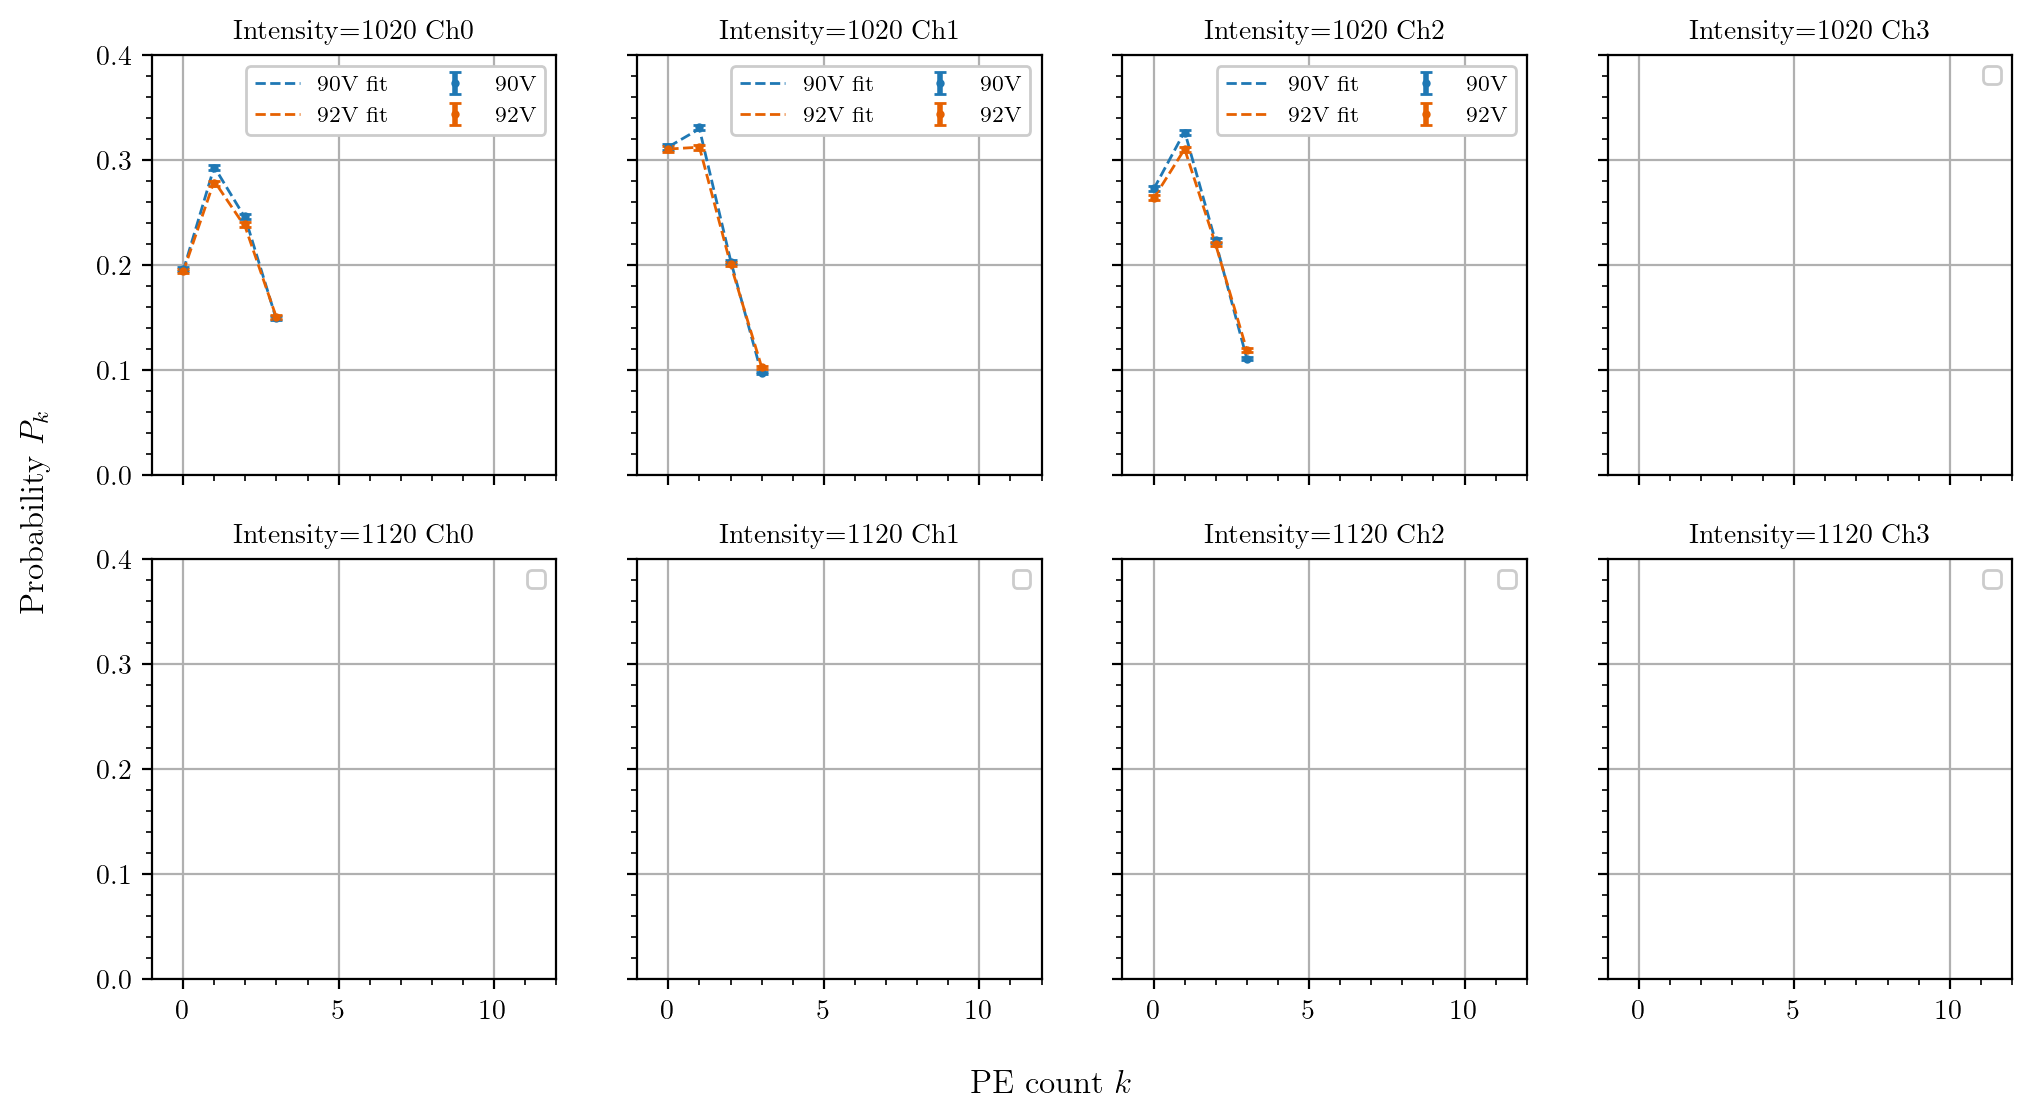

In [86]:
# Make plots for all datasets
# DiCT fits
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, intn in enumerate(intensities):
    for j, ch in enumerate(channels):
        for k, volt in enumerate(voltages):
            if 'x' in crosstalk[intn][ch][volt]:
                axs[i, j].errorbar(crosstalk[intn][ch][volt]['x'],
                                crosstalk[intn][ch][volt]['y'],
                                yerr=crosstalk[intn][ch][volt]['yerr'],
                                fmt=f'C{k}o', markersize=2, label=f'{volt}V')
                axs[i, j].plot(crosstalk[intn][ch][volt]['x'],
                            func.compound_poisson(
                                crosstalk[intn][ch][volt]['x'], *crosstalk[intn][ch][volt]['par']),
                            f'C{k}--', label=f'{volt}V fit', linewidth=1)
        axs[i, j].legend(loc='upper right', ncol=2)
        axs[i, j].set_ylim(0, 0.4)
        axs[i, j].set_xlim(-1, 12)
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'Intensity={intn} Ch{ch}')
fig.supxlabel(r'PE count $k$', y=0.01)
fig.supylabel(r'Probability $P_k$', x=0.07)

Plots for intensity=1020 ch2 90V


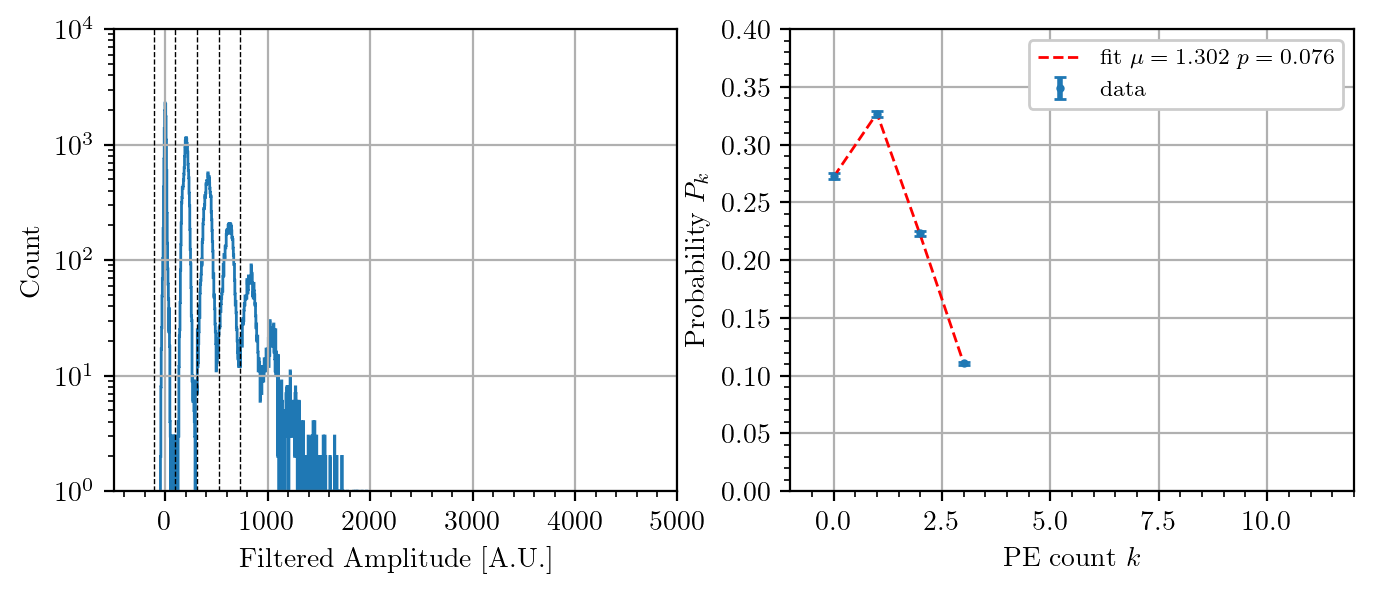

In [87]:
# Make plots for selected datasets
intn = 1020
ch = 2
volt = 90
print(f'Plots for intensity={intn} ch{ch} {volt}V')
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)

# filtered amplitude histogram
axs[0].stairs(amp_hist[intn][ch][volt]['hist'],
              amp_hist[intn][ch][volt]['bins'])
for b in amp_hist[intn][ch][volt]['boundaries']:
    axs[0].plot([b, b], [1, 1e4], 'k--', linewidth=0.5)
axs[0].set_yscale('log')
axs[0].set_xlabel('Filtered Amplitude [A.U.]')
axs[0].set_ylabel('Count')
axs[0].set_xlim(amp_hist[intn][ch][volt]['bins'][0],
                amp_hist[intn][ch][volt]['bins'][-1])
axs[0].set_ylim(1, 1e4)
axs[0].minorticks_on()
axs[0].grid()

# Vinogradov fit
axs[1].errorbar(crosstalk[intn][ch][volt]['x'],
                crosstalk[intn][ch][volt]['y'],
                yerr=crosstalk[intn][ch][volt]['yerr'],
                fmt='o', markersize=2, label='data')
axs[1].plot(crosstalk[intn][ch][volt]['x'],
            func.compound_poisson(
                crosstalk[intn][ch][volt]['x'], *crosstalk[intn][ch][volt]['par']),
            'r--', label=r'fit $\mu={:.3f}$ $p={:.3f}$'.format(*crosstalk[intn][ch][volt]['par']), linewidth=1)
axs[1].set_xlabel(r'PE count $k$')
axs[1].set_ylabel(r'Probability $P_k$')
axs[1].set_ylim(0, 0.4)
axs[1].set_xlim(-1, 12)
axs[1].legend(loc='upper right')
axs[1].minorticks_on()
axs[1].grid()

# Write to HDF5 file

In [93]:
h5filename = f'data/calibration_liq4_2023-06-07.h5'
columns = ['channel', 'A1min', 'A1max', 'bsl_rms']
for intn in intensities:
    for volt in voltages:
        store = pd.HDFStore(h5filename)
        store.put(f'{intn}/{volt}V',pd.DataFrame(np.array([[
            ch,
            amp_hist[intn][ch][volt]['boundaries'][1] if len(amp_hist[intn][ch][volt]['boundaries'])>2 else 0,
            amp_hist[intn][ch][volt]['boundaries'][2] if len(amp_hist[intn][ch][volt]['boundaries'])>2 else 0,
            mybsl[intn][ch][volt]['rms_threshold']
        ] for ch in channels]), columns=columns).astype({'channel':'int'}))
        store.close()

In [94]:
for intn in intensities:
    for volt in voltages:
        summary = pd.read_hdf('data/calibration_liq4_2023-06-07.h5', key=f'/{intn}/{volt}V')
        print(f'{intn} {volt}V')
        print(summary)

ValueError: The file 'data/calibration_liq4_2023-06-07.h5' is already opened, but not in read-only mode (as requested).